In [1]:
import numpy as np
import jmkdata
import matplotlib.pyplot as plt
%matplotlib nbagg
%load_ext autoreload
%autoreload 2


/Users/jklymak/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Over a flat bottom, the *linear* internal wave equations are separable in the vertical, and the vertical components can be written as

$$\phi_{zz} + k^2  \frac{N^2(z)-\omega^2}{\omega^2-f^2}\phi = 0$$

for the vertical velocity, with rigid-lid boundary conditions $\phi(z=0) = 0$, and $\phi(z=-H)=0$.  These are equivalent to the horizontal velocity and pressure equation:

$$ \left(\frac{1}{N^2-\omega^2} \psi_{z}\right)_{z} + k^2  \frac{1}{\omega^2-f^2}\psi = 0$$

with $P_z(z=0) = 0$ and $P_z(z=-H)=0$.

For $N(z)^2$ a constant, these are met by cosines and sines respectively with wavelengths $H/2n$, for all $n$. 

We solve these numerically with the basic idea that $(\phi_{zz})_j \approx \frac{\phi_{j-1} - 2\phi_j + \phi_{j+1}}{dz^2}$.  Discretizing, we consider interior meshpoints $dz,2dz,3dz,...M dz$, where $(M+1)dz = H$ is the water depth.  We don't solve for $z = 0,-H$ because the BC is that $\phi = 0$.

We can write this as a matrix equation:

$$ \mathbf{D}\phi = c^2\phi$$  

where $c^2$ are eigenvalues to be determined, and $\mathbf{D}$ is a tri-diagonal matrix fopr $j = 1...M-1$

$$ D_{j,j} = 2 / (dz^2 N^2(j)) $$
$$ D_{j,j-1} =D_{j,j+1} = -1 / (dz^2 N^2(j)) $$

We also note that because $\phi(z=0)=0$ then $(\phi_{zz})_0 \approx \frac{-2\phi_0 + \phi_1}{dz^2}$, and $D_{0,0} = 2/ (dz^2 N^2(0)) $ and $D_{0,1} = -1/ (dz^2 N^2(0)) $. Similarly at the bottom boundary condition.

We solve this with `numpy.linalg.eig` to get the egienvectors and eigenvalues of $\mathbf{D}$.  

After this, it is a case of data massaging to get in the form we'd like.  Much fo this is arbitrary.  However, for the practical oceanographic cases, we usually have all our variables on midpoints of the grid: $z = dz/2., 3dz/2, 5dz/2... H-dz/2$.  `vertmodes.vertModes` assumes you pass $N^2$ on this grid.  So 1) we need to interpolate $N^2$ onto the meshpoints.  Then we need to interpolate $\phi$ back to the midpoints when we are done.  

Next we calculate $\psi = \phi_z$ (from $u_x + u_z = 0$).  

Next, we make $\psi$ have a positive first entry.  

Lastly, we normalize so that  $\int \psi_{k}(z)^2 dz = 1$ for each mode $k$.

We note that 

$$ \int_{-H}^0 \psi_k \psi_j dz = \delta(j-k)$$

and 

$$ \int_{-H}^0 N^2(z) \phi_k \phi_j dz = \delta(j-k)$$



c theory: 4.9656 c[0]: 4.9658
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  3.11e-13
int psi 0 psi 2:  4.59e-13
int psi 0 psi 3:  2.76e-13
int Nsq phi 0 phi 0:  2.68e-02
int Nsq phi 0 phi 1:  3.16e-15
int Nsq phi 0 phi 2:  -1.80e-17
int Nsq phi 0 phi 3:  -1.48e-16


<IPython.core.display.Javascript object>


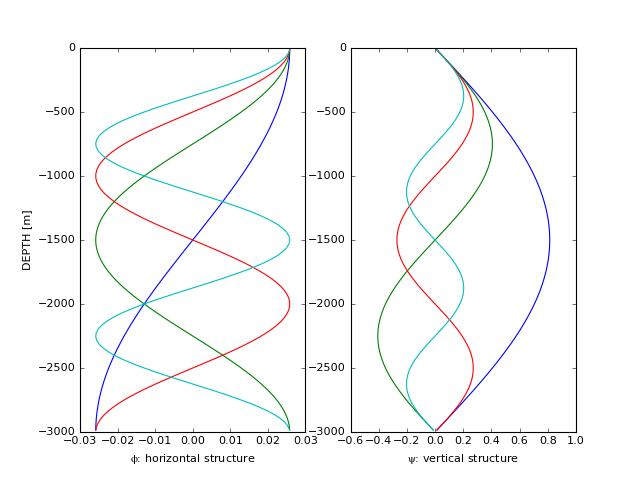

In [2]:
import vertmodes 
L = 100
Nsq = np.ones(L)*1.
dz = 1.
c = np.sqrt(Nsq[0])*L/np.pi
z0 = np.linspace(0,3000,L)
# these are the "meshpoints" for w.
dz = np.median(np.diff(z0))
z = z0[:-1]+dz/2.  # these are midpoints.

Nsq = (5.2e-3)**2*np.exp(-z/1000.)
Nsq = Nsq*0.+5.2e-3**2
c = np.mean(np.sqrt(Nsq[0]))*3000/np.pi

psi,phi,ce,zph = vertmodes.vertModes(Nsq,dz)
print "c theory: %1.4f c[0]: %1.4f"%(c,ce[0])

for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))
for i in range(4):
    print('int Nsq phi 0 phi %d:  %1.2e'%(i,np.sum(phi[:,0]*phi[:,i]*Nsq*dz)))

fig,axs=plt.subplots(1,2)
for nn in range(4):
    axs[0].plot(psi[:,nn],-zph)
    axs[1].plot(phi[:,nn],-zph)
axs[0].set_ylabel('DEPTH [m]')
axs[0].set_xlabel('$\phi$: horizontal structure')
axs[1].set_xlabel('$\psi$: vertical structure')


c theory: 4.8389 c[0]: 2.6413
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  -6.11e-16
int psi 0 psi 2:  -1.25e-15
int psi 0 psi 3:  -6.61e-15
int Nsq phi 0 phi 0 (normalized):  1.00e+00
int Nsq phi 0 phi 1 (normalized):  -2.25e-03
int Nsq phi 0 phi 2 (normalized):  -3.85e-04
int Nsq phi 0 phi 3 (normalized):  -2.99e-04


<IPython.core.display.Javascript object>


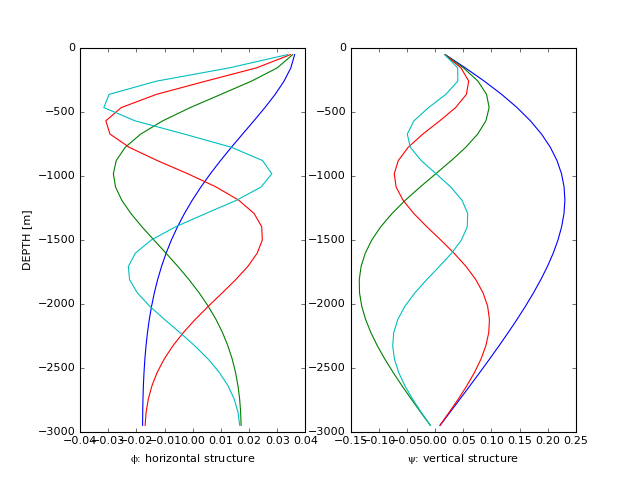

In [3]:
import vertmodes 
L = 30
Nsq = np.ones(L)*1.
dz = 1.
c = np.sqrt(Nsq[0])*L/np.pi
z0 = np.linspace(0,3000,L)
# these are the "meshpoints" for w.
dz = np.median(np.diff(z0))
z = z0[:-1]+dz/2.  # these are midpoints.

Nsq = (5.2e-3)**2*np.exp(-z/1000.)
#Nsq = Nsq*0.+5.2e-3**2
c = np.mean(np.sqrt(Nsq[0]))*3000/np.pi

psi,phi,ce,zph = vertmodes.vertModes(Nsq,dz)
print "c theory: %1.4f c[0]: %1.4f"%(c,ce[0])

for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))
for i in range(4):
    print('int Nsq phi 0 phi %d (normalized):  %1.2e'%(i,np.sum(phi[:,0]*phi[:,i]*Nsq*dz)/np.sum(phi[:,0]*phi[:,0]*Nsq*dz)))

fig,axs=plt.subplots(1,2)
for nn in range(4):
    axs[0].plot(psi[:,nn],-zph)
    axs[1].plot(phi[:,nn],-zph)
axs[0].set_ylabel('DEPTH [m]')
axs[0].set_xlabel('$\phi$: horizontal structure')
axs[1].set_xlabel('$\psi$: vertical structure')
